In [1]:
import pandas as pd
import time
from sklearn.linear_model import Ridge
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

In [2]:
def fix(X, y):
    X_omits = []
    y_omits = []
    X_copy = X.copy()
    y_copy = y.copy()
    j = 0
    for i,row in X.iterrows():
        for e in row:
            if e == -512:
                X_omits.append(X.index[j])
                y_omits.append(y.index[j])
        j += 1
    #print(len(X_omits), len(y_omits))
    X_return = X_copy.drop(X_omits)
    y_return = y_copy.drop(y_omits)
    return X_return, y_return
    

In [3]:
# TEMP SAVE 6:15 PM
df = pd.read_csv('SATALL12S.csv')
satz_df = pd.read_csv('eugene_satz.csv')
our_df = pd.read_csv('kevin_algo.csv')
ddqn_df = pd.read_csv('kevin_ddqn.csv')
start = 156 # this is the column that feature-relevant data begins
X_train = []
X_test = []

lst_r2_satz = []
lst_r2_our = []
lst_r2_ddqn = []

k_splits = 5
samples = len(df)
group_ctr = 0

best_r2_satz, best_clf_satz, idx_fg_satz = -100, -1, -1
best_r2_our, best_clf_our, idx_fg_our = -100, -1, -1
best_r2_ddqn, best_clf_ddqn, idx_fg_ddqn = -100, -1, -1

for i in range(156, len(df.columns)):
    if "featuretime" in df.columns[i]:
        avg_r2_satz = 0
        avg_r2_our = 0
        avg_r2_ddqn = 0
        avg_r2_diff_our_ddqn = 0
        
        for k in range(k_splits):
            X_train = df.iloc[np.r_[0:samples*k//k_splits, samples*(k+1)//k_splits:samples], start:i+1]
            X_test = df.iloc[samples*k//k_splits:samples*(k+1)//k_splits, start:i+1]
            
            y_satz_train = satz_df.iloc[np.r_[0:samples*k//k_splits, samples*(k+1)//k_splits:samples], -1]
            y_satz_test = satz_df.iloc[samples*k//k_splits:samples*(k+1)//k_splits, -1]
            y_our_train = our_df.iloc[np.r_[0:samples*k//k_splits, samples*(k+1)//k_splits:samples], 0]
            y_our_test = our_df.iloc[samples*k//k_splits:samples*(k+1)//k_splits, 0]
            y_ddqn_train = ddqn_df.iloc[np.r_[0:samples*k//k_splits, samples*(k+1)//k_splits:samples], 0]
            y_ddqn_test = ddqn_df.iloc[samples*k//k_splits:samples*(k+1)//k_splits:, 0]
            
            y_diff_our_ddqn_train = y_ddqn_train - y_our_train
            y_diff_our_ddqn_test = y_ddqn_test - y_our_test
            
            clf0 = Ridge(alpha=0.2, normalize = True)
            X_train_fixed, y_train_fixed = fix(X_train, y_satz_train)
            clf0.fit(X_train_fixed, y_train_fixed)
            X_test_fixed, y_test_fixed = fix(X_test, y_satz_test)
            avg_r2_satz += clf0.score(X_test_fixed, y_test_fixed)

            clf1 = Ridge(alpha=0.2, normalize = True)
            #clf1 = SVR(C=0.5)
            #clf1 = DecisionTreeRegressor()
            X_train_fixed, y_train_fixed = fix(X_train, y_our_train)
            clf1.fit(X_train_fixed, y_train_fixed)
            X_test_fixed, y_test_fixed = fix(X_test, y_our_test)
            avg_r2_our += clf1.score(X_test_fixed, y_test_fixed)
            
            clf2 = Ridge(alpha=0.2, normalize = True)
            #clf2 = SVR(C=0.5)
            #clf2 = DecisionTreeRegressor()
            X_train_fixed, y_train_fixed = fix(X_train, y_ddqn_train)
            clf2.fit(X_train_fixed, y_train_fixed)
            X_test_fixed, y_test_fixed = fix(X_test, y_ddqn_test)
            avg_r2_ddqn += clf2.score(X_test_fixed, y_test_fixed)
        
        if avg_r2_satz > best_r2_satz:
            best_r2_satz = avg_r2_satz
            best_clf_satz = clf0
            idx_fg_satz = group_ctr
        
        if avg_r2_our > best_r2_our:
            best_r2_our = avg_r2_our
            best_clf_our = clf1
            idx_fg_our = group_ctr
        
        if avg_r2_ddqn > best_r2_ddqn:
            best_r2_ddqn = avg_r2_ddqn
            best_clf_ddqn = clf2
            idx_fg_ddqn = group_ctr
        
        lst_r2_satz.append(avg_r2_satz)
        lst_r2_our.append(avg_r2_our)
        lst_r2_ddqn.append(avg_r2_ddqn)
        
        start = i+1
        group_ctr += 1
print([round(num, 2) for num in lst_r2_satz])
print([round(num, 2) for num in lst_r2_our])
print([round(num, 2) for num in lst_r2_ddqn])

print(best_r2_satz, idx_fg_satz)
print(best_r2_our, idx_fg_our)
print(best_r2_ddqn, idx_fg_ddqn)

[0.15, 0.06, 0.21, -0.7, -0.17, -0.13, -0.1, 0.01, 0.08, -0.19]
[-0.04, 0.05, 0.16, -0.01, -0.08, 0.17, 0.03, -0.1, -0.11, -0.08]
[-0.67, 0.04, -0.06, -0.09, -0.21, 0.18, -0.1, -0.14, -0.13, -0.17]
0.21226501566033262 2
0.17278944990152445 5
0.17675512277669658 5


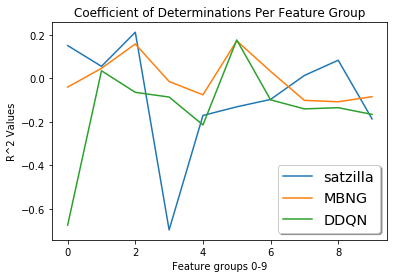

In [10]:
fig,ax = plt.subplots()
ax.plot(lst_r2_satz, label='satzilla')
ax.plot(lst_r2_our, label='MBNG')
ax.plot(lst_r2_ddqn, label='DDQN')
plt.title("Coefficient of Determinations Per Feature Group")
plt.ylabel("R^2 Values")
plt.xlabel("Feature groups 0-9")
#plt.legend((lst_r2_satz, lst_r2_our, lst_r2_ddqn), ('satzilla', 'MBNG', 'DDQN'))
legend = ax.legend(loc='lower right', shadow=True, fontsize='x-large')

In [11]:
satz_times = list(satz_df.iloc[:,-1])
ouralgo_times = list(our_df.iloc[:,0])
ddqn_times = list(ddqn_df.iloc[:,0])
wins = 0
macro_app = 0
for r_idx in range(len(satz_times)):
    if ouralgo_times[r_idx] < satz_times[r_idx] or ddqn_times[r_idx] < satz_times[r_idx]:
        wins += 1
    
abc = 0
ab = 0
bc = 0
ac = 0
examples = 0

satz_weight = 1
ouralgo_weight = 7
ddqn_weight = 12

for r_idx in range(len(satz_df)):
    
    grp2 = satz_df.iloc[r_idx, 23:44]
    grp5 = satz_df.iloc[r_idx, 61:80]
    overhead = satz_df.iloc[r_idx,43] + satz_df.iloc[r_idx, 79]
    sattime = best_clf_satz.predict([grp2])
    ourtime = best_clf_our.predict([grp5])
    ddqntime = best_clf_ddqn.predict([grp5])
    
    actuals = [sattime, ourtime, ddqntime]
    end = False
    for term in actuals:
        if term < 0:
            end = True
            break
    if end:
        continue
        
    
    predicts = [satz_times[r_idx], ouralgo_times[r_idx], ddqn_times[r_idx]]
    
    if satz_weight * predicts[0] < ouralgo_weight * predicts[1] and satz_weight * predicts[0] < ddqn_weight * predicts[2]:
        abc += actuals[0]
    elif ouralgo_weight * predicts[1] < satz_weight * predicts[0] and ouralgo_weight * predicts[1] < ddqn_weight * predicts[2]:
        abc += actuals[1]
    else:
        abc += actuals[2]
    
    
    if satz_weight * predicts[0] < ouralgo_weight * predicts[1]:
        ab += actuals[0]
    else:
        ab += actuals[1]
    
    if ouralgo_weight * predicts[1] < ddqn_weight * predicts[2]:
        bc += actuals[1]
    else:
        bc += actuals[2]
    
    if satz_weight * predicts[0] < ddqn_weight * predicts[2]:
        ac += actuals[0]
    else:
        ac += actuals[2]
    
    examples += 1
    
print("Avg. Runtime ABC:", (abc/examples)[0])
print("Avg. Runtime AB: ", (ab/examples)[0])
print("Avg. Runtime BC: ", (bc/examples)[0])
print("Avg. Runtime AC: ", (ac/examples)[0])

#print(abc / examples, ab/examples, bc/examples, ac/examples, examples)
#print(our_satz, ddqn_satz, our_ddqn)
# print("Our algo vs. SATZ accuracy:", round((our_satz[0] + our_satz[1]) / sum(our_satz), 2))
# print("DDQN vs. SATZ accuracy:", round((ddqn_satz[0] + ddqn_satz[1]) / sum(ddqn_satz), 2))
# print("Our algo vs. DDQN accuracy:", round((our_ddqn[0] + our_ddqn[1]) / sum(our_ddqn), 2))
# print("Outperformed SATZ:", absolute_correct/len(satz_df))

Avg. Runtime ABC: 283.93138149076566
Avg. Runtime AB:  287.1193521363812
Avg. Runtime BC:  325.5012467650398
Avg. Runtime AC:  287.46596055054977
